# Analysis of the Evolution of Loads by Interconnection

This notebook analyzes the time series of annual total and annual peak loads from TELL by interconnection.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/figures/'


## Process the TELL Output Files

In [3]:
# Read in the BA-to-Interconnection mapping file:
ba_mapping = pd.read_csv(data_output_dir + 'BA_to_Interconnection_Mapping.csv')


In [4]:
# Check to see if the processed output file exist and if not then create it:
if os.path.isfile((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv'))) == False:

   # Set the scenarios to process:
   scenarios = ['historic', 'rcp45cooler_ssp3', 'rcp45cooler_ssp5', 'rcp45hotter_ssp3', 'rcp45hotter_ssp5', 'rcp85cooler_ssp3', 'rcp85cooler_ssp5', 'rcp85hotter_ssp3', 'rcp85hotter_ssp5']

   #Initiate a counter and empty dataframe to store the results:
   counter = 0;
   output_df = pd.DataFrame()

   # Loop over the scenarios and process each time series:
   for s in range(len(scenarios)):
       if scenarios[s] == 'historic':
          start_year = 1980; end_year = 2020; interval = 1
       else:
          start_year = 2020; end_year = 2100; interval = 5
        
       # Loop over the years from the start_year to the end_year in 5-year increments:
       for year in range(start_year,end_year,interval):
           # Read in the TELL BA output file for that year and scenario:
           tell_df = pd.read_csv(data_input_dir + 'outputs/tell_output/' + scenarios[s] + '/' + str(year) + '/TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
             
           # Merge in the interconnection mapping using common BA codes:
           merged_df = pd.merge(tell_df, ba_mapping, on='BA_Code')
            
           # Sum the BA-level hourly loads into annual interconnection-level hourly loads:
           merged_df['Interconnection_Load_TWh'] = merged_df.groupby(['Interconnection', 'Time_UTC'])['Scaled_TELL_BA_Load_MWh'].transform('sum')    
            
           # Only keep the columns we need and subset to the unique values:
           merged_df = merged_df[['Time_UTC', 'Interconnection', 'Interconnection_Load_TWh']].drop_duplicates()
            
           # Make a list of all of the interconnections in the 'merged_df':
           ics = merged_df['Interconnection'].unique()
         
           # Loop over the interconnections and calculate the total and peak load for each year:
           for i in range(len(ics)):
               # Iterate the counter by one:
               counter = counter + 1
            
               # Subset to just the data for the interconnection being processed:
               subset_df = merged_df[merged_df['Interconnection'].isin([ics[i]])].copy()
          
               # Put the output in a new dataframe:
               output_df.loc[counter, 'Scenario'] = scenarios[s]
               output_df.loc[counter, 'Year'] = int(year)
               output_df.loc[counter, 'Interconnection'] = ics[i]
               output_df.loc[counter, 'Total_Load_TWh'] = (subset_df['Interconnection_Load_TWh'].sum().round(6)) / 1000000
               output_df.loc[counter, 'Peak_Load_MWh'] = subset_df['Interconnection_Load_TWh'].max()
            
               # Clean up
               del subset_df

           # Clean up
           del tell_df, merged_df, ics
         
   # Initiate an empty normalized load variable:
   output_df['Total_Load_Normalized'] = np.nan
   output_df['Peak_Load_Normalized'] = np.nan

   # Loop over the rows of the dataframe normalize the load by the base year value:
   for row in range(len(output_df)):
       # Find the total load value to normalize by:
       base_load = output_df['Total_Load_TWh'].loc[(output_df['Year'] == 2019) & 
                                                   (output_df['Interconnection'] == output_df['Interconnection'].iloc[row]) & 
                                                   (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized total load:
       output_df['Total_Load_Normalized'].iloc[row] = (output_df['Total_Load_TWh'].iloc[row] / base_load).round(3)
    
       # Find the peak load value to normalize by:
       peak_load = output_df['Peak_Load_MWh'].loc[(output_df['Year'] == 2019) & 
                                                  (output_df['Interconnection'] == output_df['Interconnection'].iloc[row]) & 
                                                  (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized peak load:
       output_df['Peak_Load_Normalized'].iloc[row] = (output_df['Peak_Load_MWh'].iloc[row] / peak_load).round(3)
    
       # Clean up
       del base_load, peak_load

   # Write out the dataframe to a .csv file:
   output_df.to_csv((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv')), sep=',', index=False)
   
else:
   # Read in the already processed output file:
   output_df = pd.read_csv((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv')))            
                  
# Preview the future dataframe:
output_df


/var/folders/tw/332pg48n0cb0jrl9_s87l48m0000gn/T/ipykernel_17055/3776930447.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Total_Load_Normalized'].iloc[row] = (output_df['Total_Load_TWh'].iloc[row] / base_load).round(3)
/var/folders/tw/332pg48n0cb0jrl9_s87l48m0000gn/T/ipykernel_17055/3776930447.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Peak_Load_Normalized'].iloc[row] = (output_df['Peak_Load_MWh'].iloc[row] / peak_load).round(3)


,Scenario,Year,Interconnection,Total_Load_TWh,Peak_Load_MWh,Total_Load_Normalized,Peak_Load_Normalized
1,historic,1980.0,EIC,1128.946390,211209.54,0.370,0.374
2,historic,1980.0,WECC,271.553552,49354.14,0.346,0.352
3,historic,1980.0,ERCOT,98.568596,20498.56,0.298,0.309
4,historic,1981.0,EIC,1239.220032,229536.84,0.406,0.407
5,historic,1981.0,WECC,300.363276,52510.30,0.382,0.374
...,...,...,...,...,...,...,...
500,rcp85hotter_ssp5,2090.0,WECC,2076.945934,418573.20,2.644,2.982
501,rcp85hotter_ssp5,2090.0,ERCOT,884.716670,189372.20,2.675,2.856
502,rcp85hotter_ssp5,2095.0,EIC,7634.480872,1503712.24,2.502,2.664
503,rcp85hotter_ssp5,2095.0,WECC,2205.210686,438906.82,2.807,3.127


In [29]:
# Define a function to plot the time series of annual demand for each interconnection:
def plot_interconnection_load_time_series(data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the output file:
    output_df = pd.read_csv((os.path.join(data_output_dir, 'Interconnection_Load_Time_Series.csv')))
    
    # Subset to the time series for each interconnection and scenario:
    eic_historic = output_df[output_df['Scenario'].isin(['historic']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp45cooler_ssp3 = output_df[output_df['Scenario'].isin(['rcp45cooler_ssp3']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp45cooler_ssp5 = output_df[output_df['Scenario'].isin(['rcp45cooler_ssp5']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp45hotter_ssp3 = output_df[output_df['Scenario'].isin(['rcp45hotter_ssp3']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp45hotter_ssp5 = output_df[output_df['Scenario'].isin(['rcp45hotter_ssp5']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp85cooler_ssp3 = output_df[output_df['Scenario'].isin(['rcp85cooler_ssp3']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp85cooler_ssp5 = output_df[output_df['Scenario'].isin(['rcp85cooler_ssp5']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp85hotter_ssp3 = output_df[output_df['Scenario'].isin(['rcp85hotter_ssp3']) & output_df['Interconnection'].isin(['EIC'])]
    eic_rcp85hotter_ssp5 = output_df[output_df['Scenario'].isin(['rcp85hotter_ssp5']) & output_df['Interconnection'].isin(['EIC'])]

    wecc_historic = output_df[output_df['Scenario'].isin(['historic']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp45cooler_ssp3 = output_df[output_df['Scenario'].isin(['rcp45cooler_ssp3']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp45cooler_ssp5 = output_df[output_df['Scenario'].isin(['rcp45cooler_ssp5']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp45hotter_ssp3 = output_df[output_df['Scenario'].isin(['rcp45hotter_ssp3']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp45hotter_ssp5 = output_df[output_df['Scenario'].isin(['rcp45hotter_ssp5']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp85cooler_ssp3 = output_df[output_df['Scenario'].isin(['rcp85cooler_ssp3']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp85cooler_ssp5 = output_df[output_df['Scenario'].isin(['rcp85cooler_ssp5']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp85hotter_ssp3 = output_df[output_df['Scenario'].isin(['rcp85hotter_ssp3']) & output_df['Interconnection'].isin(['WECC'])]
    wecc_rcp85hotter_ssp5 = output_df[output_df['Scenario'].isin(['rcp85hotter_ssp5']) & output_df['Interconnection'].isin(['WECC'])]
    
    ercot_historic = output_df[output_df['Scenario'].isin(['historic']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp45cooler_ssp3 = output_df[output_df['Scenario'].isin(['rcp45cooler_ssp3']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp45cooler_ssp5 = output_df[output_df['Scenario'].isin(['rcp45cooler_ssp5']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp45hotter_ssp3 = output_df[output_df['Scenario'].isin(['rcp45hotter_ssp3']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp45hotter_ssp5 = output_df[output_df['Scenario'].isin(['rcp45hotter_ssp5']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp85cooler_ssp3 = output_df[output_df['Scenario'].isin(['rcp85cooler_ssp3']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp85cooler_ssp5 = output_df[output_df['Scenario'].isin(['rcp85cooler_ssp5']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp85hotter_ssp3 = output_df[output_df['Scenario'].isin(['rcp85hotter_ssp3']) & output_df['Interconnection'].isin(['ERCOT'])]
    ercot_rcp85hotter_ssp5 = output_df[output_df['Scenario'].isin(['rcp85hotter_ssp5']) & output_df['Interconnection'].isin(['ERCOT'])]
    
    
    # Make the plot:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 13
    
    plt.subplot(231)
    plt.plot(eic_historic['Year'], eic_historic['Total_Load_TWh'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(eic_rcp45cooler_ssp3['Year'], eic_rcp45cooler_ssp3['Total_Load_TWh'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(eic_rcp45cooler_ssp5['Year'], eic_rcp45cooler_ssp5['Total_Load_TWh'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(eic_rcp45hotter_ssp3['Year'], eic_rcp45hotter_ssp3['Total_Load_TWh'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(eic_rcp45hotter_ssp5['Year'], eic_rcp45hotter_ssp5['Total_Load_TWh'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(eic_rcp85cooler_ssp3['Year'], eic_rcp85cooler_ssp3['Total_Load_TWh'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(eic_rcp85cooler_ssp5['Year'], eic_rcp85cooler_ssp5['Total_Load_TWh'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(eic_rcp85hotter_ssp3['Year'], eic_rcp85hotter_ssp3['Total_Load_TWh'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(eic_rcp85hotter_ssp5['Year'], eic_rcp85hotter_ssp5['Total_Load_TWh'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title('EIC Total Load Projections')
    plt.title('a)', loc='left', fontsize=13)
    
    plt.subplot(232)
    plt.plot(wecc_historic['Year'], wecc_historic['Total_Load_TWh'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(wecc_rcp45cooler_ssp3['Year'], wecc_rcp45cooler_ssp3['Total_Load_TWh'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(wecc_rcp45cooler_ssp5['Year'], wecc_rcp45cooler_ssp5['Total_Load_TWh'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(wecc_rcp45hotter_ssp3['Year'], wecc_rcp45hotter_ssp3['Total_Load_TWh'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(wecc_rcp45hotter_ssp5['Year'], wecc_rcp45hotter_ssp5['Total_Load_TWh'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(wecc_rcp85cooler_ssp3['Year'], wecc_rcp85cooler_ssp3['Total_Load_TWh'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(wecc_rcp85cooler_ssp5['Year'], wecc_rcp85cooler_ssp5['Total_Load_TWh'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(wecc_rcp85hotter_ssp3['Year'], wecc_rcp85hotter_ssp3['Total_Load_TWh'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(wecc_rcp85hotter_ssp5['Year'], wecc_rcp85hotter_ssp5['Total_Load_TWh'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title('WECC Total Load Projections')
    plt.title('b)', loc='left', fontsize=13)
    
    plt.subplot(233)
    plt.plot(ercot_historic['Year'], ercot_historic['Total_Load_TWh'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(ercot_rcp45cooler_ssp3['Year'], ercot_rcp45cooler_ssp3['Total_Load_TWh'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(ercot_rcp45cooler_ssp5['Year'], ercot_rcp45cooler_ssp5['Total_Load_TWh'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(ercot_rcp45hotter_ssp3['Year'], ercot_rcp45hotter_ssp3['Total_Load_TWh'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(ercot_rcp45hotter_ssp5['Year'], ercot_rcp45hotter_ssp5['Total_Load_TWh'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(ercot_rcp85cooler_ssp3['Year'], ercot_rcp85cooler_ssp3['Total_Load_TWh'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(ercot_rcp85cooler_ssp5['Year'], ercot_rcp85cooler_ssp5['Total_Load_TWh'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(ercot_rcp85hotter_ssp3['Year'], ercot_rcp85hotter_ssp3['Total_Load_TWh'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(ercot_rcp85hotter_ssp5['Year'], ercot_rcp85hotter_ssp5['Total_Load_TWh'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title('ERCOT Total Load Projections')
    plt.title('c)', loc='left', fontsize=13)
    
    plt.subplot(234)
    plt.plot(eic_historic['Year'], eic_historic['Peak_Load_MWh']*0.001, color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(eic_rcp45cooler_ssp3['Year'], eic_rcp45cooler_ssp3['Peak_Load_MWh']*0.001, color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(eic_rcp45cooler_ssp5['Year'], eic_rcp45cooler_ssp5['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(eic_rcp45hotter_ssp3['Year'], eic_rcp45hotter_ssp3['Peak_Load_MWh']*0.001, color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(eic_rcp45hotter_ssp5['Year'], eic_rcp45hotter_ssp5['Peak_Load_MWh']*0.001, color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(eic_rcp85cooler_ssp3['Year'], eic_rcp85cooler_ssp3['Peak_Load_MWh']*0.001, color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(eic_rcp85cooler_ssp5['Year'], eic_rcp85cooler_ssp5['Peak_Load_MWh']*0.001, color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(eic_rcp85hotter_ssp3['Year'], eic_rcp85hotter_ssp3['Peak_Load_MWh']*0.001, color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(eic_rcp85hotter_ssp5['Year'], eic_rcp85hotter_ssp5['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title('EIC Peak Load Projections')
    plt.title('d)', loc='left', fontsize=13)
    
    plt.subplot(235)
    plt.plot(wecc_historic['Year'], wecc_historic['Peak_Load_MWh']*0.001, color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(wecc_rcp45cooler_ssp3['Year'], wecc_rcp45cooler_ssp3['Peak_Load_MWh']*0.001, color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(wecc_rcp45cooler_ssp5['Year'], wecc_rcp45cooler_ssp5['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(wecc_rcp45hotter_ssp3['Year'], wecc_rcp45hotter_ssp3['Peak_Load_MWh']*0.001, color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(wecc_rcp45hotter_ssp5['Year'], wecc_rcp45hotter_ssp5['Peak_Load_MWh']*0.001, color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(wecc_rcp85cooler_ssp3['Year'], wecc_rcp85cooler_ssp3['Peak_Load_MWh']*0.001, color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(wecc_rcp85cooler_ssp5['Year'], wecc_rcp85cooler_ssp5['Peak_Load_MWh']*0.001, color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(wecc_rcp85hotter_ssp3['Year'], wecc_rcp85hotter_ssp3['Peak_Load_MWh']*0.001, color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(wecc_rcp85hotter_ssp5['Year'], wecc_rcp85hotter_ssp5['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title('WECC Peak Load Projections')
    plt.title('e)', loc='left', fontsize=13)
    
    plt.subplot(236)
    plt.plot(ercot_historic['Year'], ercot_historic['Peak_Load_MWh']*0.001, color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(ercot_rcp45cooler_ssp3['Year'], ercot_rcp45cooler_ssp3['Peak_Load_MWh']*0.001, color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(ercot_rcp45cooler_ssp5['Year'], ercot_rcp45cooler_ssp5['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(ercot_rcp45hotter_ssp3['Year'], ercot_rcp45hotter_ssp3['Peak_Load_MWh']*0.001, color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(ercot_rcp45hotter_ssp5['Year'], ercot_rcp45hotter_ssp5['Peak_Load_MWh']*0.001, color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(ercot_rcp85cooler_ssp3['Year'], ercot_rcp85cooler_ssp3['Peak_Load_MWh']*0.001, color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(ercot_rcp85cooler_ssp5['Year'], ercot_rcp85cooler_ssp5['Peak_Load_MWh']*0.001, color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(ercot_rcp85hotter_ssp3['Year'], ercot_rcp85hotter_ssp3['Peak_Load_MWh']*0.001, color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(ercot_rcp85hotter_ssp5['Year'], ercot_rcp85hotter_ssp5['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title('ERCOT Peak Load Projections')
    plt.title('f)', loc='left', fontsize=13)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Interconnection_Load_Projections.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


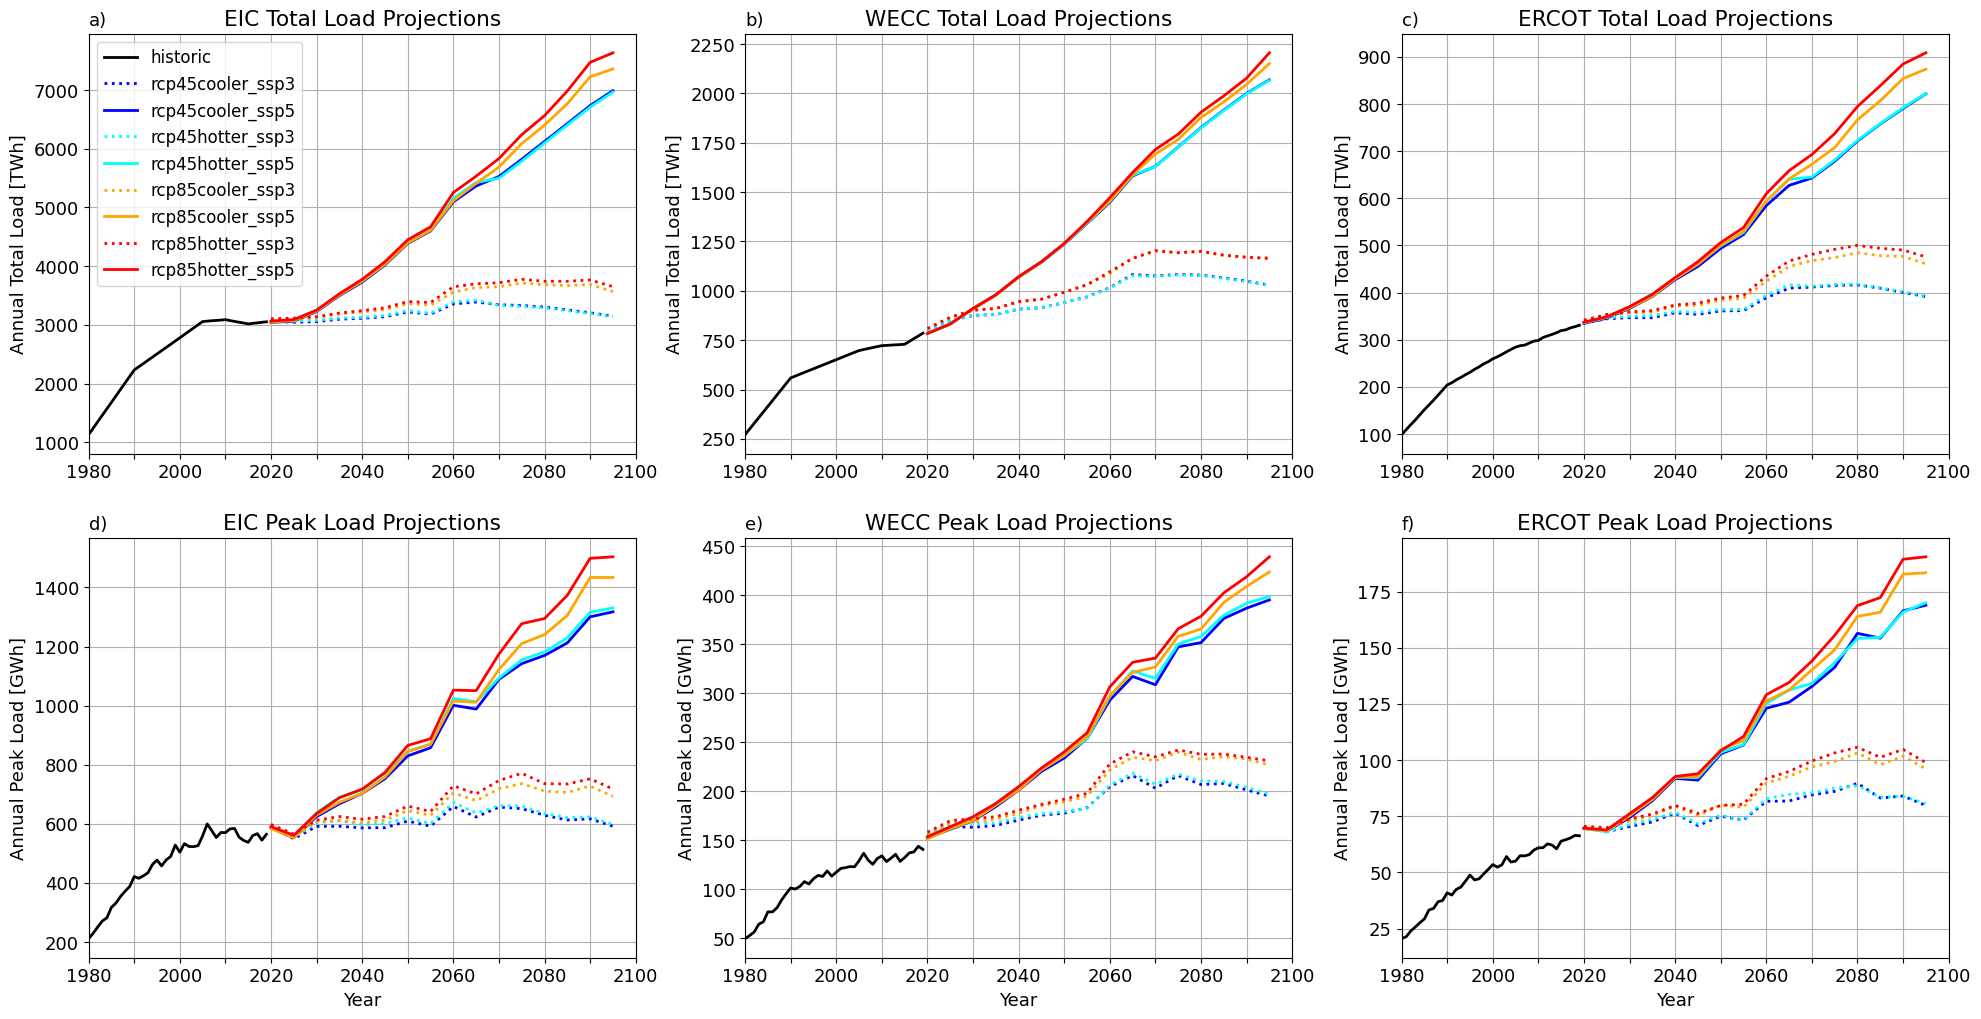

In [28]:
a = plot_interconnection_load_time_series(data_input_dir = data_output_dir, 
                                          image_output_dir = image_output_dir, 
                                          image_resolution = 300, 
                                          save_images = False)

a
